# <center> Incremental Capstone Project 4 </center>

In [255]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [256]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    PowerTransformer,
    QuantileTransformer,
    MinMaxScaler,
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder
)
from sklearn.feature_extraction import FeatureHasher
from sklearn.impute import KNNImputer

## Loadind data and initial examination using head()

In [257]:
df = pd.read_csv("NSMES1988_Dirty.csv")

print(df.head(25))


    visits  nvisits  ovisits  novisits  emergency  hospital   health  chronic  \
0      5.0      0.0      0.0       0.0        0.0       1.0  average      2.0   
1      1.0      0.0      2.0       0.0        2.0       0.0  average      2.0   
2     13.0      0.0      0.0       0.0        3.0       3.0     poor      4.0   
3     16.0      0.0      5.0       0.0        1.0       1.0     poor      2.0   
4      3.0      0.0      0.0       0.0        NaN       0.0  average      2.0   
5     17.0      0.0      0.0       0.0        0.0       0.0     poor      5.0   
6      9.0      0.0      0.0       0.0        0.0       0.0  average      0.0   
7      3.0     -1.0      0.0       1.0        NaN       0.0  average      0.0   
8      1.0      0.0      NaN       0.0        0.0       0.0  average      0.0   
9      0.0      0.0      0.0       0.0        0.0       0.0  average      0.0   
10     0.0      0.0      0.0       0.0        0.0       0.0  average      1.0   
11    43.0      4.0      2.0

#### Examine a random sample of the data frame using sample()

In [258]:
print(df.sample(n=25))

      visits  nvisits  ovisits  novisits  emergency  hospital   health  \
641     10.0      4.0      0.0       0.0        0.0       0.0  average   
3971     0.0      0.0      NaN       0.0        0.0       NaN  average   
3665     6.0      1.0      0.0       0.0        0.0       0.0  average   
2379     7.0      1.0      0.0       0.0        1.0       1.0  average   
138     39.0      3.0      2.0       2.0        0.0       1.0  average   
2789     5.0      0.0      0.0       NaN        0.0       0.0  average   
1767     0.0      0.0      0.0       0.0        0.0       0.0  average   
743      4.0      1.0      1.0       NaN        0.0       0.0     poor   
2223     0.0      0.0      0.0       0.0        NaN       0.0  average   
3480     2.0      4.0      NaN       0.0        0.0       0.0  average   
130     -1.0      2.0      0.0       0.0        0.0       0.0  average   
2124     1.0      0.0      0.0       0.0        0.0       0.0  average   
2025     0.0     -1.0      0.0       N

### Describe issues with the data

In [259]:
for col in df.columns:
    if df[col].dtype == object:
        print(col)
        for val in df[col].unique():
            print(val)
        print()

health
average
poor
excellent

adl
normal
limited

region
other
midwest
northeast
west

gender
male
female

married
yes
no

employed
yes
no

insurance
yes
no
nan

medicaid
no
yes



In [260]:
print(df.describe())

            visits      nvisits      ovisits     novisits    emergency  \
count  4186.000000  4186.000000  4186.000000  4186.000000  4186.000000   
mean      6.006928     1.615862     0.728141     0.550406     0.262303   
std       7.361932     5.308146     3.594853     4.120928     0.694748   
min      -2.000000    -1.000000    -1.000000    -1.000000     0.000000   
25%       1.000000     0.000000     0.000000     0.000000     0.000000   
50%       4.000000     0.000000     0.000000     0.000000     0.000000   
75%       8.000000     1.000000     0.000000     0.000000     0.000000   
max      94.000000   103.000000   139.000000   162.000000    12.000000   

          hospital      chronic          age       school       income  
count  4186.000000  4186.000000  4186.000000  4186.000000  4186.000000  
mean      0.299092     1.544434     8.023777    10.306737     2.686016  
std       0.755314     1.345841     2.904519     3.739043     3.243288  
min       0.000000     0.000000     6.727

1. Several columns show negative values where negative value are not realistic
1. The age column show individuals with ages greater the the expected max of ~12.5 (125 years old)

#### Count the number of outliers using Interquartile Range (IQR) Method
Per Google IQR is robust to skewed distributions.

In [261]:
#Calculate the IQR for each column
for col in df.columns:
    if df[col].dtype != object:
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_bound =  df[col].quantile(0.25) - 1.5 * iqr
        upper_bound =  df[col].quantile(0.75) + 1.5 * iqr
        print(f'Column {col} - IQR: {iqr} - Upper Bound: {upper_bound} - Lower Bound: {lower_bound}')
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        if not outliers.empty:
            outlier_count = outliers.count()
            print(f'Column: {col} number of outliers {outlier_count}')

Column visits - IQR: 7.0 - Upper Bound: 18.5 - Lower Bound: -9.5
Column: visits number of outliers 186
Column nvisits - IQR: 1.0 - Upper Bound: 2.5 - Lower Bound: -1.5
Column: nvisits number of outliers 596
Column ovisits - IQR: 0.0 - Upper Bound: 0.0 - Lower Bound: 0.0
Column: ovisits number of outliers 971
Column novisits - IQR: 0.0 - Upper Bound: 0.0 - Lower Bound: 0.0
Column: novisits number of outliers 736
Column emergency - IQR: 0.0 - Upper Bound: 0.0 - Lower Bound: 0.0
Column: emergency number of outliers 767
Column hospital - IQR: 0.0 - Upper Bound: 0.0 - Lower Bound: 0.0
Column: hospital number of outliers 824
Column chronic - IQR: 1.0 - Upper Bound: 3.5 - Lower Bound: -0.5
Column: chronic number of outliers 368
Column age - IQR: 0.9528092420534886 - Upper Bound: 9.50291220108635 - Lower Bound: 5.691675232872394
Column: age number of outliers 129
Column school - IQR: 4.0 - Upper Bound: 18.0 - Lower Bound: 2.0
Column: school number of outliers 110
Column income - IQR: 2.3600362

In [262]:
for col in df.columns:
    if df[col].dtype == object:
        print(col)
        for val in df[col].unique():
            print(val)
        print()

health
average
poor
excellent

adl
normal
limited

region
other
midwest
northeast
west

gender
male
female

married
yes
no

employed
yes
no

insurance
yes
no
nan

medicaid
no
yes



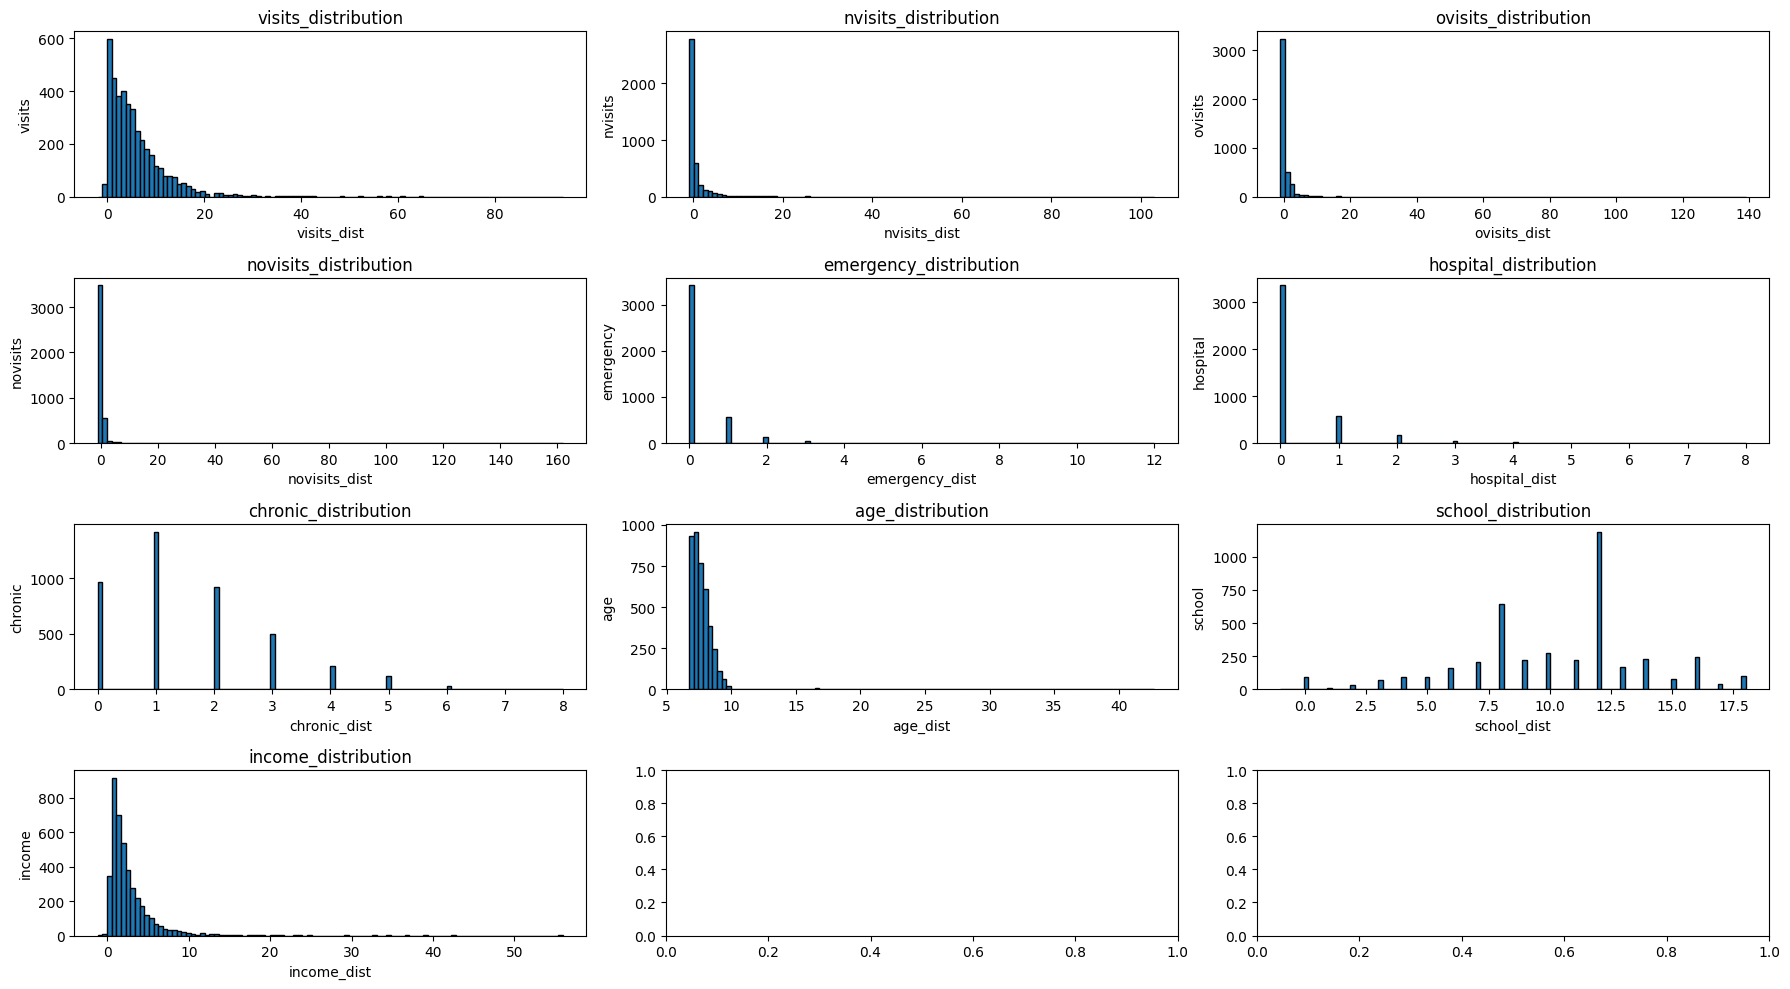

In [263]:
number_columns = []

for col in df.columns:
    if df[col].dtype != 'object':
        number_columns.append(col)

num_plot_cols = 3
num_plot_rows = len(number_columns) // num_plot_cols
if (len(number_columns) % 3 != 0):
    num_plot_rows += 1

fig, axes = plt.subplots(num_plot_rows, num_plot_cols, figsize=(18, 10))

for plot_row in range(0,num_plot_rows):
    plot_col = len(number_columns) - (num_plot_cols *  plot_row)
    if plot_col > num_plot_cols:
        plot_col = num_plot_cols

    for plot_col in range(0,plot_col):
        column_index = plot_row * num_plot_cols + plot_col
        axes[plot_row,plot_col].set_title(f'{number_columns[column_index]}_distribution')
        axes[plot_row,plot_col].hist(df[f'{number_columns[column_index]}'], bins=100, edgecolor='black')
        axes[plot_row,plot_col].set_ylabel(f'{number_columns[column_index]}')
        axes[plot_row,plot_col].set_xlabel(f'{number_columns[column_index]}_dist')

plt.tight_layout()
plt.show()

    

## Data Wrangling


### Remove invalid values

In [264]:
for col in df.columns:
    if df[col].dtype == "object":
        print(col)
        for val in df[col].unique():
            print(val)
        print()

health
average
poor
excellent

adl
normal
limited

region
other
midwest
northeast
west

gender
male
female

married
yes
no

employed
yes
no

insurance
yes
no
nan

medicaid
no
yes



In [265]:
for col in df.columns:
    if df[col].dtype != "object":
        print(col)
        df[(df[col] < 0)][col] = 0
        

visits
nvisits
ovisits
novisits
emergency
hospital
chronic
age
school
income


/tmp/ipykernel_314236/4164819249.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df[col] < 0)][col] = 0


In [266]:
for col in df.columns:
    if df[col].dtype == "object":
        print(col)
        for val in df[col].unique():
            print(val)
        print()

health
average
poor
excellent

adl
normal
limited

region
other
midwest
northeast
west

gender
male
female

married
yes
no

employed
yes
no

insurance
yes
no
nan

medicaid
no
yes



### Data Imputation
Using the mean method to fill in missing values

In [267]:
df_filled = df.copy()
for col in df.columns:
    if df[col].dtype != 'object':
        col_mean_value = df[col].mean()
        df[f'{col}_mean'] = df[col].fillna(col_mean_value)
        print(f'Missing values in column {col} are being replace with the mean value {col_mean_value}')

print(df.info())

Missing values in column visits are being replace with the mean value 6.0069278547539415
Missing values in column nvisits are being replace with the mean value 1.615862398471094
Missing values in column ovisits are being replace with the mean value 0.7281414237935977
Missing values in column novisits are being replace with the mean value 0.5504061156235069
Missing values in column emergency are being replace with the mean value 0.2623029144768275
Missing values in column hospital are being replace with the mean value 0.29909221213569037
Missing values in column chronic are being replace with the mean value 1.5444338270425226
Missing values in column age are being replace with the mean value 8.023776639431205
Missing values in column school are being replace with the mean value 10.30673674151935
Missing values in column income are being replace with the mean value 2.6860157557784543
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4406 entries, 0 to 4405
Data columns (total 28 columns)

In [268]:
for col in df.columns:
    if df[col].dtype == object:
        print(col)
        for val in df[col].unique():
            print(val)
        print()

health
average
poor
excellent

adl
normal
limited

region
other
midwest
northeast
west

gender
male
female

married
yes
no

employed
yes
no

insurance
yes
no
nan

medicaid
no
yes



Remove Duplicates

In [269]:
print(f'Data Frame contains {len(df)} records before removing duplicates')
df.drop_duplicates()
print(f'Data Frame contains {len(df)} records after removing duplicates')

Data Frame contains 4406 records before removing duplicates
Data Frame contains 4406 records after removing duplicates


Remove outliers using IQR

In [270]:
#Calculate the IQR for each column
print(f'Data Frame contains {len(df)} records')
for col in df.columns:
    if df[col].dtype != object and "mean" in col:
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_bound =  df[col].quantile(0.25) - 1.5 * iqr
        upper_bound =  df[col].quantile(0.75) + 1.5 * iqr
        print(f'Column {col} - IQR: {iqr} - Upper Bound: {upper_bound} - Lower Bound: {lower_bound}')
        if lower_bound != upper_bound:
            df[(df[col] < lower_bound)][col] = lower_bound
            df[(df[col] > upper_bound)][col] = upper_bound
            #outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            #if not outliers.empty:
            #    df.drop(outliers.index,inplace=True)
    df.reset_index()

print(f'Data Frame contains {len(df)} records')


Data Frame contains 4406 records
Column visits_mean - IQR: 6.0 - Upper Bound: 17.0 - Lower Bound: -7.0
Column nvisits_mean - IQR: 1.0 - Upper Bound: 2.5 - Lower Bound: -1.5
Column ovisits_mean - IQR: 0.7281414237935977 - Upper Bound: 1.8203535594839944 - Lower Bound: -1.0922121356903967
Column novisits_mean - IQR: 0.0 - Upper Bound: 0.0 - Lower Bound: 0.0
Column emergency_mean - IQR: 0.0 - Upper Bound: 0.0 - Lower Bound: 0.0
Column hospital_mean - IQR: 0.0 - Upper Bound: 0.0 - Lower Bound: 0.0
Column chronic_mean - IQR: 1.0 - Upper Bound: 3.5 - Lower Bound: -0.5
Column age_mean - IQR: 0.9029733698588833 - Upper Bound: 9.39240786415443 - Lower Bound: 5.780514384718897
Column school_mean - IQR: 4.0 - Upper Bound: 18.0 - Lower Bound: 2.0
Column income_mean - IQR: 2.222696292600541 - Upper Bound: 6.547915885557192 - Lower Bound: -2.3428692848449724
Data Frame contains 4406 records


/tmp/ipykernel_314236/2741845590.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df[col] > upper_bound)][col] = upper_bound
/tmp/ipykernel_314236/2741845590.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df[col] > upper_bound)][col] = upper_bound
/tmp/ipykernel_314236/2741845590.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

### Updating catagory data.

### Text field encoding

In [275]:
# Define the order for ordinal encoding

for col in df.columns:
    if df[col].dtype == object:
        print(col)
        for val in df[col].unique():
            print(val)
        
        
        encoder = OrdinalEncoder(categories=categories)
        newcolname = col + "_encode"
        #xformcol = []
        #xformcol.append(df[col])
        df[newcolname] = encoder.fit_transform([df[col]])

#print(df)

health
average
poor
excellent


ValueError: Shape mismatch: if categories is an array, it has to be of shape (n_features,).